<a href="https://colab.research.google.com/github/GZabalaG/AIMaster/blob/main/Supervised/Actividad_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import cv2 as cv

Mounted at /content/drive


#### Cargar una de las imágenes histológicas

<function matplotlib.pyplot.show>

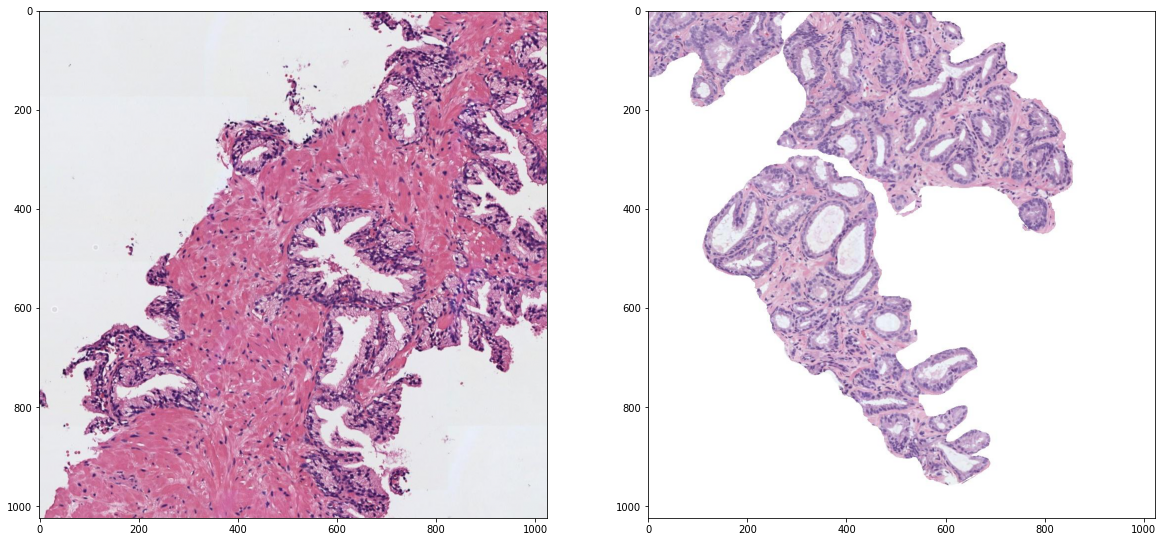

In [3]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
from skimage import io
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20, 10))


histo_1_pre = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_1.jpeg')
histo_2_pre = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_2.jpeg')

# Recuerda normalizar la imagen diviéndola entre 255
histo_1 = histo_1_pre/255
histo_2 = histo_2_pre/255

ax[0].imshow(histo_1, cmap='gray')
ax[1].imshow(histo_2, cmap='gray')
plt.show

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

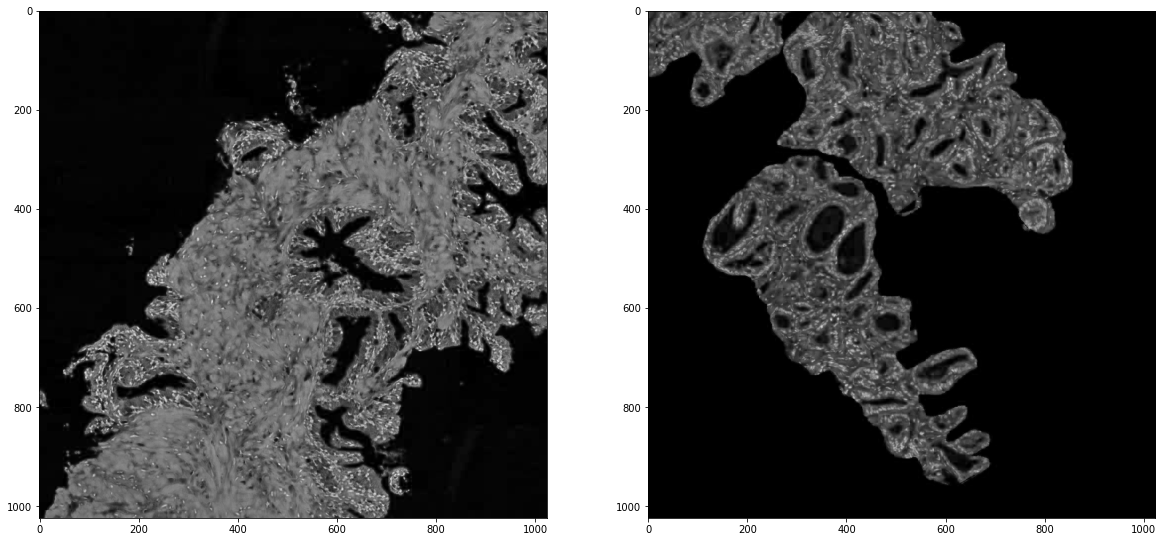

True

In [4]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)

with np.errstate(invalid='ignore', divide='ignore'):
   k1 = 1 - np.max(histo_1, axis=2)
   m1 = (1-histo_1[...,1] - k1)/(1-k1)

   k2 = 1 - np.max(histo_2, axis=2)
   m2 = (1-histo_2[...,1] - k2)/(1-k2)

# 2) Visualiza la imagen con la librería de matplotlib.
fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(m1, cmap='gray')
ax[1].imshow(m2, cmap='gray')
plt.show()

# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"

cv.imwrite('1_imagen_magenta1.png', m1)
cv.imwrite('1_imagen_magenta2.png', m2)

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

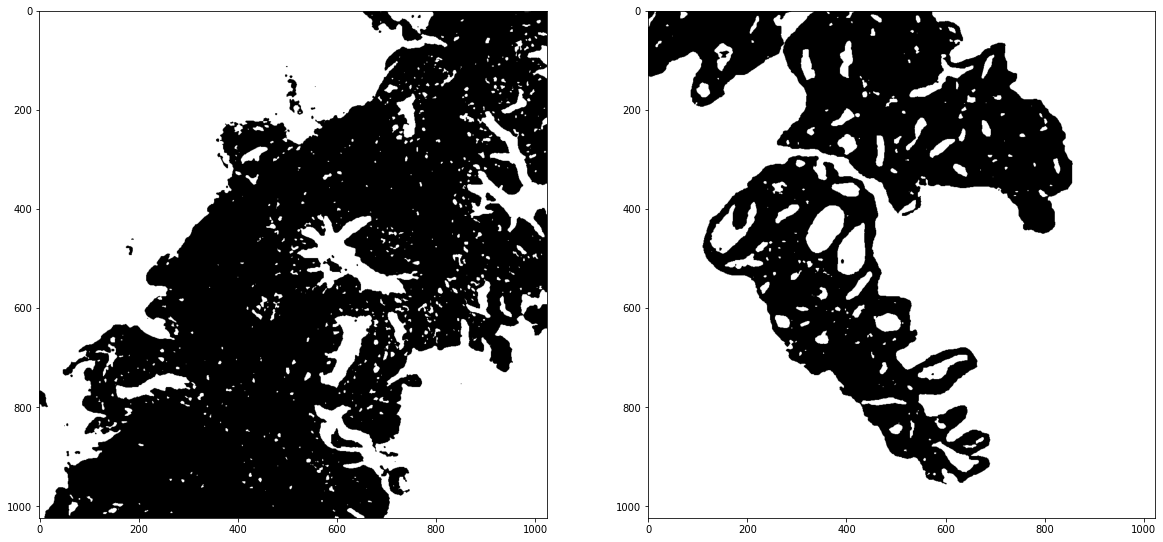

True

In [5]:
# 1) Convierte la imagen Magenta a formato "uint8"

m1u8 = (m1*255).astype('uint8')
m2u8 = (m2*255).astype('uint8')

# 2) Aplica un filtro gaussiano de tamaño 5x5

gauss1 = cv.GaussianBlur(m1u8,(5,5),0)
gauss2 = cv.GaussianBlur(m2u8,(5,5),0)

# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 

t, mask_1 = cv.threshold(gauss1, 0, 1, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
t, mask_2 = cv.threshold(gauss2, 0, 1, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# 5) Visualiza la máscara resultante (imagen de 0s y 1s)

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(mask_1, cmap='gray')
ax[1].imshow(mask_2, cmap='gray')
plt.show()

# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"

mask_1 = mask_1 * 255
mask_2 = mask_2 * 255

cv.imwrite('2_mascara_con_artefactos1.png', mask_1)
cv.imwrite('2_mascara_con_artefactos2.png', mask_2)

#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

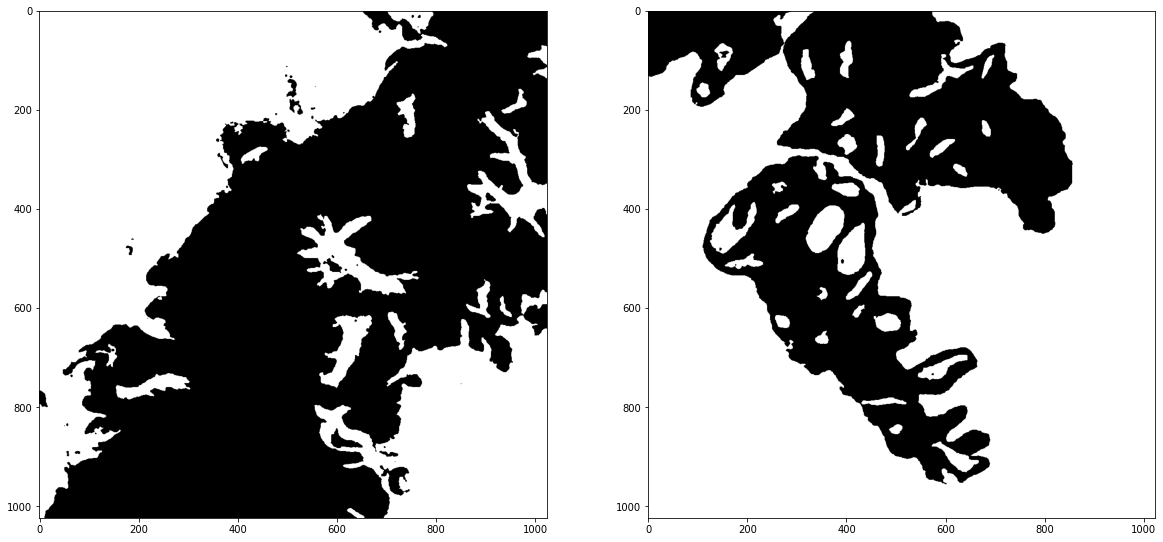

True

In [6]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects. 
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.

from skimage import morphology

removed_1 = morphology.remove_small_objects((mask_1//255).astype(bool), 300, connectivity=8)
removed_2 = morphology.remove_small_objects((mask_2//255).astype(bool), 300, connectivity=8)

# 2) Convierte la máscara generada en formato uint8

removed_1 = (removed_1).astype('uint8')
removed_2 = (removed_2).astype('uint8')

# 3) Visualiza la máscara resultante

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(removed_1, cmap='gray')
ax[1].imshow(removed_2, cmap='gray')
plt.show()

# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"
removed_1 = removed_1 * 255
removed_2 = removed_2 * 255

cv.imwrite('3_mascara_sin_artefactos1.png', removed_1)
cv.imwrite('3_mascara_sin_artefactos2.png', removed_2)

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

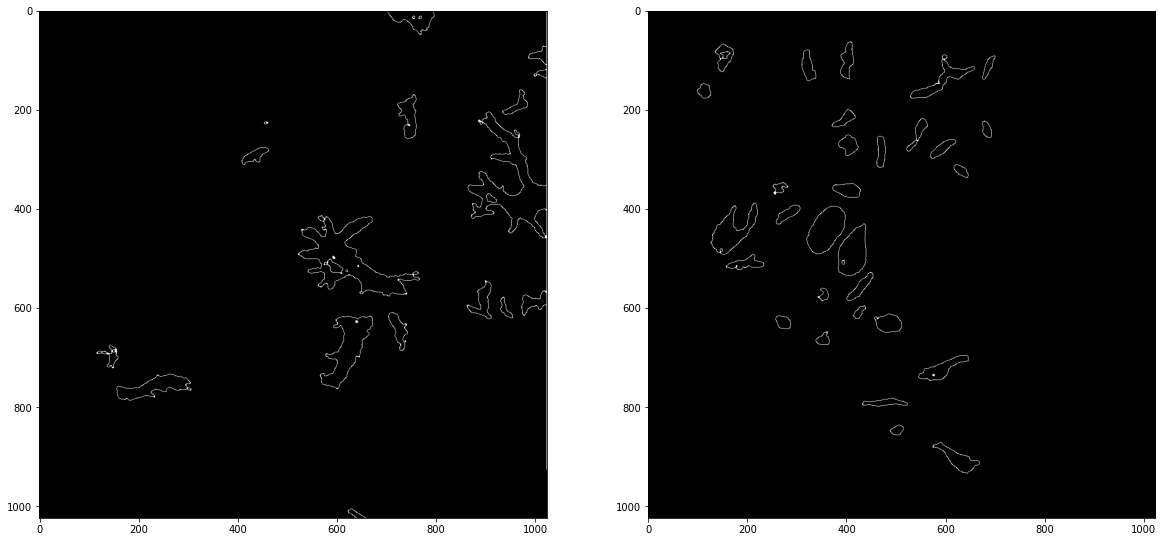

True

In [7]:
# 1) Aplica el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.

pre_canny1 = removed_1 // 255
pre_canny2 = removed_2 // 255

# Dibujamos una linea en la derecha de la imagen 1 para poder captar los lúmenes que sobresalen de la imagen

def plot_lines(img, color = (255, 255, 255)):
  height, width = img.shape
  x1_r, y1_r = width-1, 1
  x2_r, y2_r = width-1, height-100

  cv.line(img, (x1_r, y1_r), (x2_r, y2_r), color, 2)

plot_lines(pre_canny1)

h1, w1 = pre_canny1.shape
h2, w2 = pre_canny2.shape

ref1 = np.zeros((h1+2, w1+2), np.uint8)
ref2 = np.zeros((h2+2, w2+2), np.uint8)

cv.floodFill(pre_canny1, ref1, (0,0), 0)
cv.floodFill(pre_canny2, ref2, (0,0), 0)

cv.floodFill(pre_canny1, ref1, (pre_canny1.shape[0]-1,pre_canny1.shape[1]-1), 0)
cv.floodFill(pre_canny2, ref2, (pre_canny2.shape[0]-1,pre_canny2.shape[1]-1), 0)

### PASO EXTRA: El siguiente enunciado estaría completo sin sacar contornos con canny. 
# Como se pide rellenar con binary_fill_holes se necesita partir de una máscara con objetos identificados

canny1 = cv.Canny(pre_canny1, 1/3, 1)
canny2 = cv.Canny(pre_canny2, 1/3, 1)

kernel = np.ones((2,2), 'uint8')

canny1 = cv.dilate(canny1, kernel, iterations=2)
canny2 = cv.dilate(canny2, kernel, iterations=2)

canny1 = cv.erode(canny1, kernel, iterations=2)
canny2 = cv.erode(canny2, kernel, iterations=2)

# 2) Visualiza la máscara resultante

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(canny1, cmap='gray')
ax[1].imshow(canny2, cmap='gray')
plt.show()

# 3) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"
canny1 = canny1 * 255
canny2 = canny2 * 255

cv.imwrite('4_mascara_lumenes1.png', canny1)
cv.imwrite('4_mascara_lumenes2.png', canny2)

#### Rellenar los objetos de los lúmenes

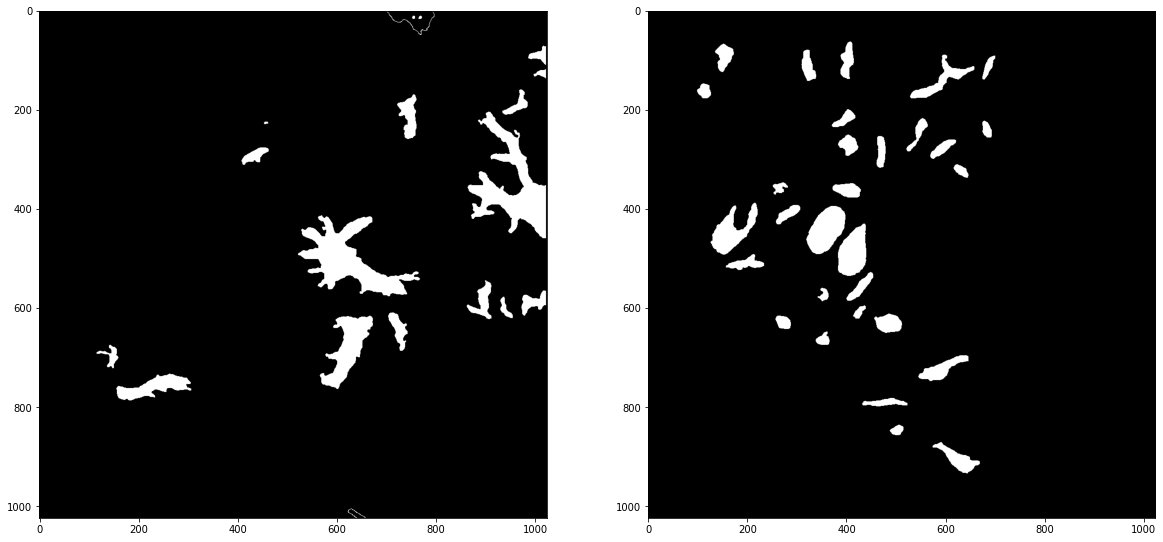

True

In [8]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
from scipy import ndimage

bin_fill_1 = ndimage.morphology.binary_fill_holes(canny1).astype('uint8')
bin_fill_2 = ndimage.morphology.binary_fill_holes(canny2).astype('uint8')

### Borramos las lineas auxiliares:

plot_lines(bin_fill_1, (0,0,0))

# 3) Visualiza la máscara

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(bin_fill_1, cmap='gray')
ax[1].imshow(bin_fill_2, cmap='gray')
plt.show()

# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"
bin_fill_1 = bin_fill_1 * 255
bin_fill_2 = bin_fill_2 * 255

cv.imwrite('5_mascara_final1.png', bin_fill_1)
cv.imwrite('5_mascara_final2.png', bin_fill_2)

#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

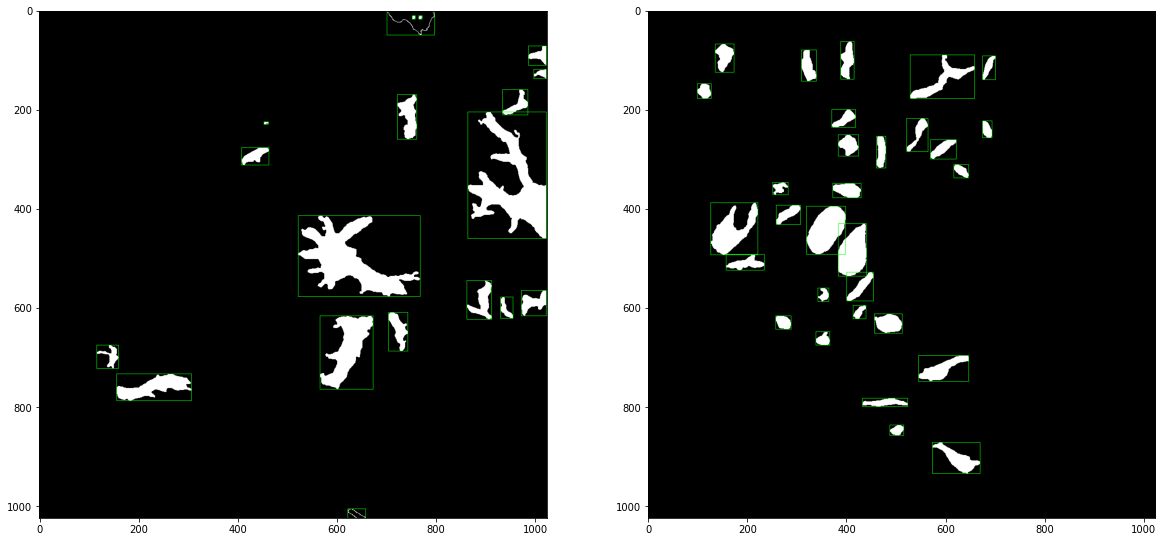

True

In [9]:
from google.colab.patches import cv2_imshow

# 1) Encuentra los contornos de los lúmenes

contours1, hierarchy1 = cv.findContours(bin_fill_1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours2, hierarchy2 = cv.findContours(bin_fill_2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

rgb_contour1 = cv.cvtColor(bin_fill_1,cv.COLOR_GRAY2RGB)
rgb_contour2 = cv.cvtColor(bin_fill_2,cv.COLOR_GRAY2RGB)

# 2) Dibuja los contornos (de color verde) sobre la imagen original

for contour in contours1:
    x,y,w,h = cv.boundingRect(contour)
    cv.rectangle(rgb_contour1,(x,y),(x+w,y+h),(0,255,0),1)

for contour in contours2:
    x,y,w,h = cv.boundingRect(contour)
    cv.rectangle(rgb_contour2,(x,y),(x+w,y+h),(0,255,0),1)

# 3) Visualiza la imagen superpuesta

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(rgb_contour1, cmap='gray')
ax[1].imshow(rgb_contour2, cmap='gray')
plt.show()

# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"

cv.imwrite('6_imagen_superpuesta1.png', rgb_contour1)
cv.imwrite('6_imagen_superpuesta2.png', rgb_contour2)

#### Identificar y cropear el lumen más grande

Areas imagen 1 (pixels):

Area lumen 1 = 183
Area lumen 2 = 32
Area lumen 3 = 36
Area lumen 4 = 646
Area lumen 5 = 256
Area lumen 6 = 922
Area lumen 7 = 2031
Area lumen 8 = 14308
Area lumen 9 = 35
Area lumen 10 = 956
Area lumen 11 = 14709
Area lumen 12 = 1622
Area lumen 13 = 1281
Area lumen 14 = 457
Area lumen 15 = 1424
Area lumen 16 = 6852
Area lumen 17 = 700
Area lumen 18 = 3891
Area lumen 19 = 73


Areas imagen 2 (pixels):

Area lumen 1 = 1297
Area lumen 2 = 1280
Area lumen 3 = 1144
Area lumen 4 = 2653
Area lumen 5 = 556
Area lumen 6 = 607
Area lumen 7 = 792
Area lumen 8 = 873
Area lumen 9 = 480
Area lumen 10 = 1068
Area lumen 11 = 921
Area lumen 12 = 904
Area lumen 13 = 477
Area lumen 14 = 426
Area lumen 15 = 1227
Area lumen 16 = 4292
Area lumen 17 = 899
Area lumen 18 = 5017
Area lumen 19 = 4435
Area lumen 20 = 1164
Area lumen 21 = 1090
Area lumen 22 = 343
Area lumen 23 = 358
Area lumen 24 = 1588
Area lumen 25 = 653
Area lumen 26 = 497
Area lumen 27 = 2122
Area lumen 28 = 923
Area 

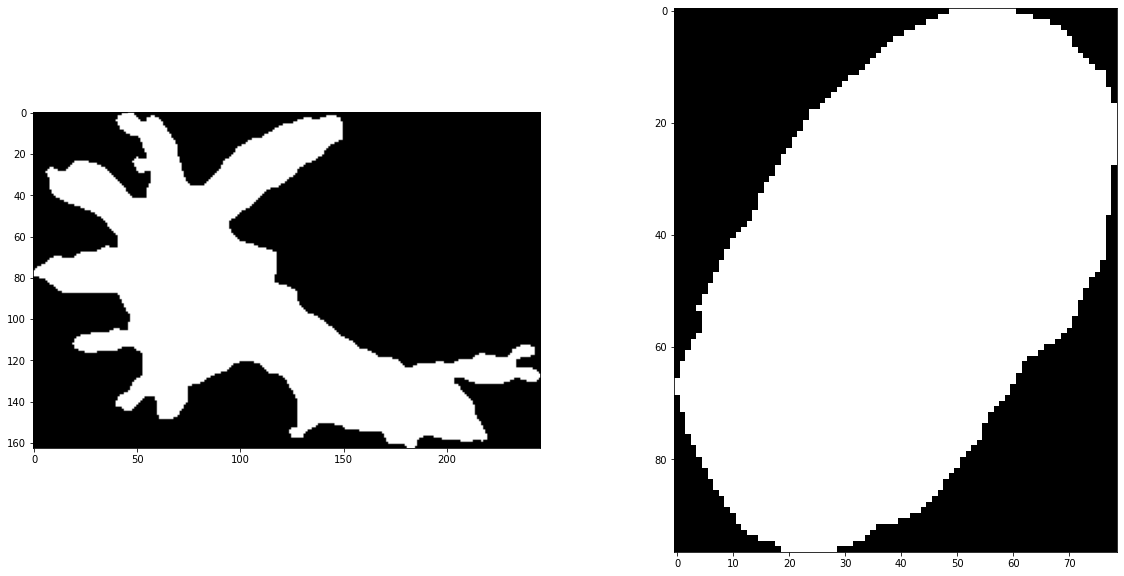

True

In [77]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
from skimage.measure import regionprops
from skimage.measure import label

lab1, num1 = label(bin_fill_1, return_num=True)
lab2, num2 = label(bin_fill_2, return_num=True)

v1, c1 = np.unique(lab1, return_counts=True)
v2, c2 = np.unique(lab2, return_counts=True)

# 2) Calcula el área de cada uno de los lúmenes 

print('Areas imagen 1 (pixels):\n')
area1 = lab1 == 1 # Para el proximo ejercicio. Obtenemos el lumen con mayor area en este bucle para no volver a iterar. Menor coste
for i in range(1,num1+1):
  object1 = lab1 == i
  prop1 = regionprops(object1.astype('uint8'))
  area = prop1[0].area
  if area > regionprops(area1.astype('uint8'))[0].area:
    area1 = lab1 == i
  print('Area lumen', i, '=', area)

print('\n\nAreas imagen 2 (pixels):\n')
area2 = lab2 ==  1 # Para el proximo ejercicio. Obtenemos el lumen con mayor area en este bucle para no volver a iterar. Menor coste
for i in range(1,num2+1):
  object2 = lab2 == i
  prop2 = regionprops(object2.astype('uint8'))
  area = prop2[0].area
  if area > regionprops(area2.astype('uint8'))[0].area:
    area2 = lab2 == i
  print('Area lumen', i, '=', area)

# 3) Obtén una máscara del lumen de mayor área

area1 = area1.astype('uint8')
area2 = area2.astype('uint8')

# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box

prop1 = regionprops(area1)
prop2 = regionprops(area2)

bbox1 = prop1[0].bbox
bbox2 = prop2[0].bbox

crop1 = area1[bbox1[0]:bbox1[2], bbox1[1]:bbox1[3]]
crop2 = area2[bbox2[0]:bbox2[2], bbox2[1]:bbox2[3]]

# 5) Visualiza la máscara recortada del lumen

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(crop1, cmap='gray')
ax[1].imshow(crop2, cmap='gray')
plt.show()

# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"

crop1 = crop1*255
crop2 = crop2*255

cv.imwrite('7_crop_image1.png', crop1)
cv.imwrite('7_crop_image2.png', crop2)


#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [79]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad

from tabulate import tabulate
import math

new_lab, new_num = label(crop1, return_num=True)

# Extraemos las característicias geométricas
headers = ['','Figura 1']
A,BB,CA,E,ED,EX,MA,MiA,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    
    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
    R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers))

                  Figura 1
--------------  ----------
area            14709
bbox_area       40098
convex_area     29530
eccentricity        0.8462
equiv_diameter    136.851
extent              0.3668
major_axis        241.264
minor_axis        128.571
perimeter        1209.34
solidity            0.4981
compactness         0.1264
rectangularity      0.3668
